# Recovering statistics from edge-sampled networks

In this notebook we will investigate empirically how different statistics behave on networks that are edge-sampled, without any temporal analysis for the moment

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from collections import Counter
a4_dims = (11.69,8.27)

Simple function which returns from a given networkx graph G a graph H, the induced subgraph from a random proportion p of H's edges.

In [2]:
def edge_sample(G, p):
    edges = G.edges()
    sampled=[]
    for e in edges:
        r = random.random()
        if r < p:
            sampled.append(e)
    H = nx.Graph()
    H.add_edges_from(sampled)
    return H

Returns a vector of degrees and cdf from a networkx graph G

In [3]:
def get_deg_cdf(G):
    cts = Counter(sorted([d for n, d in G.degree()]))
    degs = sorted(cts.keys())
    vals = [cts[val] for val in degs]
    cdf = np.cumsum(vals)
    ccdf = cdf[-1] - cdf
    return degs, cdf

More generally returns an empirical cdf of values 

In [4]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum

In [5]:
def setup_axes(x,y,xscale="linear",yscale="linear"):
    fig, ax = plt.subplots(figsize = a4_dims)
    ax.set_xlabel(x,fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.set_ylabel(y, fontsize=20)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    return fig, ax

In [6]:
#G = nx.gnp_random_graph(1000, 0.005)
G = nx.barabasi_albert_graph(10000,3)
n = len(G.nodes())
m = len(G.edges())
k = 2*m/n
print(m)

29991


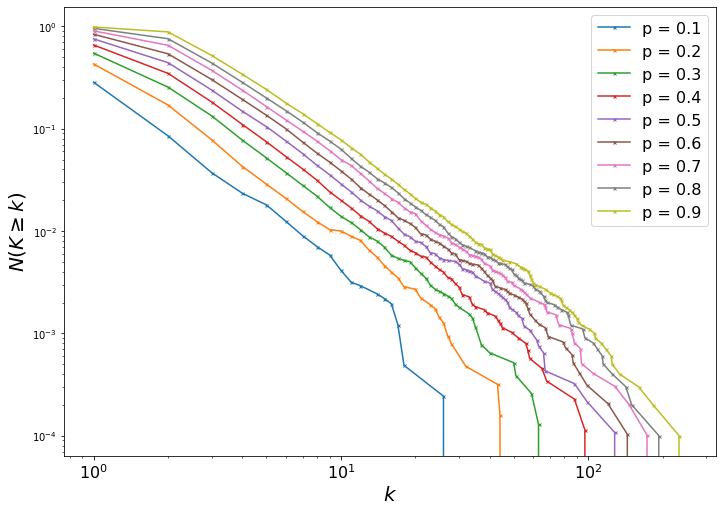

In [7]:
prange = np.linspace(0.1,0.9,9)
edges = G.edges()

fig, ax = setup_axes('$k$','$N(K\\geq k)$','log','log')

for p in prange:
    H = edge_sample(G,p)
    degs, cdf = get_deg_cdf(H)
    ccdf = 1-cdf/cdf[-1]
    ax.plot(degs, ccdf,marker='x',markersize=3,label="p = "+str(round(p,1)))
    
ax.legend(fontsize=16)
plt.show()

Estimate the original degree by using the estimator ki = 1/p * ki'.

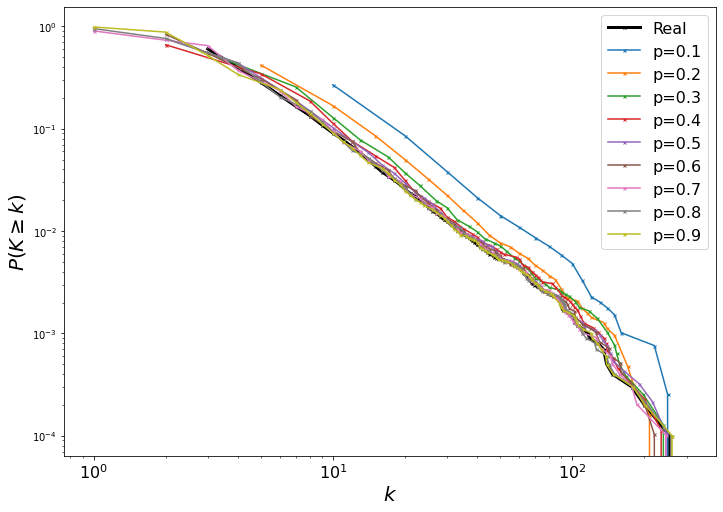

In [8]:
prange = np.linspace(0.1,0.9,9)
edges = G.edges()

fig, ax = setup_axes('$k$','$P(K\\geq k)$','log','log')

degs, cdf = get_deg_cdf(G)
ccdf = 1 - cdf/cdf[-1]
ax.plot(degs, ccdf,marker='x',markersize=3,label="Real", linewidth=3, color="black")

for p in prange:
    H = edge_sample(G,p)
    degrees = [d for n,d in nx.degree(H)]
    rescaled = sorted([np.round(d/p) for d in degrees])
    degs, cdf = ecdf(rescaled)
#     cts = Counter(rescaled)
#     degs = sorted(cts.keys())
#     vals = [cts[val] for val in degs]
#     cdf = np.cumsum(vals)
    ccdf = cdf[-1] - cdf
    ccdf = 1-cdf/cdf[-1]
    ax.plot(degs, ccdf,marker='x',markersize=3,label="p="+str(round(p,1)))
    
ax.legend(fontsize=16)
plt.show()

Too harsh to use this MLE. For example, no degrees possible in range (0, 1/p). Try relax this to find an estimator for k_i using likelihood.

## Triangle Count

In [52]:
def triangles(n1, n2, G):
    if not G.has_edge(n1,n2):
        return 0
    else:
        return len(list(nx.common_neighbors(G,n1,n2)))
    
def edge_triangle_count(G):
    tc = []
    for i in G.nodes():
        for j in G.neighbors(i):
            if i>j:
                continue
            tc.append(triangles(i,j,G))
    return tc

def common_neighbours(n1, n2, G):
    n1neigh = set(G.neighbors(n1))
    n2neigh = set(G.neighbors(n2))
    return len(n1neigh.intersection(n2neigh)), G.has_edge(n1,n2)

def edge_neighbour_count(G):
    ec = []
    for i in sorted(G.nodes()):
        for j in sorted(G.nodes()):
            if j>i:
                break
            cn = common_neighbours(i,j,G)
            if cn[0]!=0:
                ec.append(cn)
    return ec
            
print(common_neighbours(1,2,G))

(0, False)


In [57]:
def improved_triangle_count(tri_array,p):
    return [round(1.0/p**2*x[0]) for x in tri_array]

In [10]:
def MME_triangle_count(tri_array, p):
    return [round(1.0/p**3*ct) for ct in tri_array]

In [11]:
def tot_tri_estimate(G,p):
    H = edge_sample(G,p)
    tri_array = edge_triangle_count(H)/p**3
    return sum(tri_array)/3.0

473.0
0.0
250.0
259.0
446.6666666666667
464.0
497.0
488.6666666666667
476.0
390.0


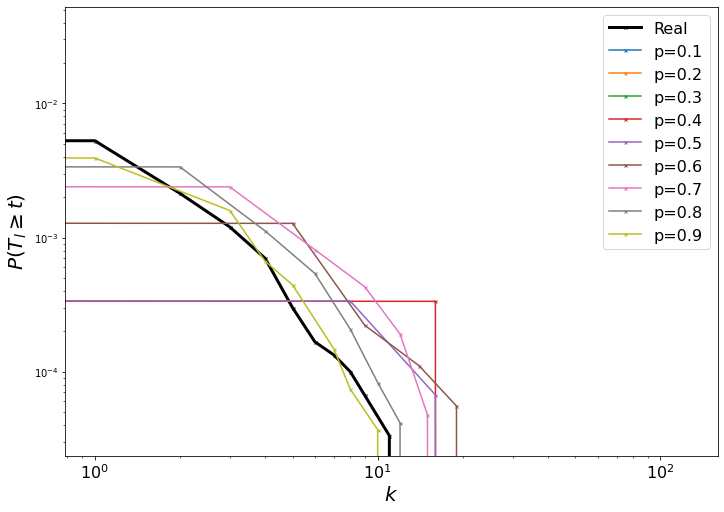

In [58]:
fig, ax = setup_axes('$k$','$P(T_l\\geq t)$','log','log')
G = nx.barabasi_albert_graph(10000,3)
# fname="/Users/naomiarnold/CODE/NaomiFETA/FETA3.1/experiments/facebook/facebook.dat"
# net = pd.read_csv(fname,sep=" ",names=["source","target","t"])
# net = net.drop(["t"], axis=1)
# G = nx.from_pandas_edgelist(net)

tc = edge_triangle_count(G)
print(sum(tc)/3.0)
tri, cdf = ecdf(tc)
ccdf = 1 - cdf/cdf[-1]

ax.plot(tri, ccdf,marker='x',markersize=3,label="Real", linewidth=3, color="black")

prange = np.linspace(0.1,0.9,9)

for p in prange:
    H = edge_sample(G,p)
    tc_sampled = edge_triangle_count(H)
    tc_estimate = MME_triangle_count(tc_sampled,p)
    print(sum(tc_estimate)/3.0)
    tri, cdf = ecdf(tc_estimate)
    ccdf = 1 - cdf/cdf[-1]
    ax.plot(tri, ccdf,marker='x',markersize=3,label="p="+str(round(p,1)))
    
ax.legend(fontsize=16)
plt.show()

1148
2885
5931
9232
13991
19213
25100
32585
40655


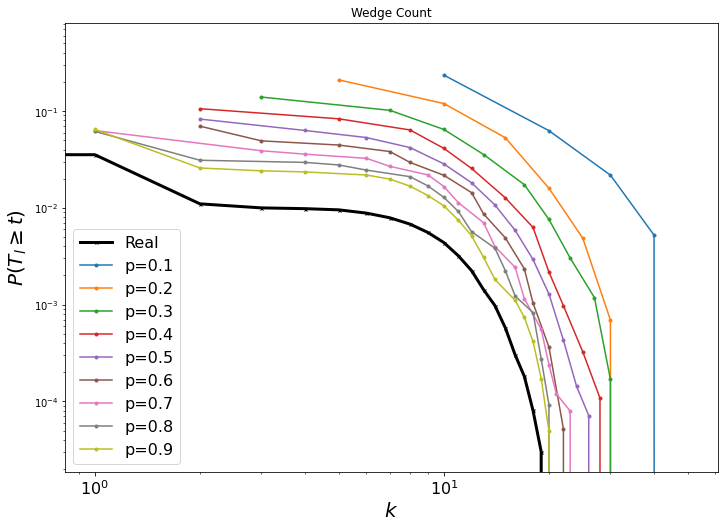

In [56]:
fig, ax = setup_axes('$k$','$P(T_l\\geq t)$','log','log')
G = nx.gnp_random_graph(1000,0.01)
# fname="/Users/naomiarnold/CODE/NaomiFETA/FETA3.1/experiments/facebook/facebook.dat"
# net = pd.read_csv(fname,sep=" ",names=["source","target","t"])
# net = net.drop(["t"], axis=1)
# G = nx.from_pandas_edgelist(net)

ec = edge_neighbour_count(G)
#print(sum([x[0] for x in ec] )/2.0)
tri, cdf = ecdf(ec)
ccdf = 1 - cdf/cdf[-1]

ax.plot(tri, ccdf,marker='x',markersize=3,label="Real", linewidth=3, color="black")
ax.set_title("Wedge Count")
prange = np.linspace(0.1,0.9,9)

for p in prange:
    H = edge_sample(G,p)
    ec_sampled = edge_neighbour_count(H)
    ec_estimate = improved_triangle_count(ec_sampled,p)
    print(len(ec_estimate))
    #print(sum([x[0] for x in ec_estimate])/3.0)
    tri, cdf = ecdf(ec_estimate)
    ccdf = 1 - cdf/cdf[-1]
    ax.plot(tri, ccdf,marker='o',markersize=3,label="p="+str(round(p,1)))
    
ax.legend(fontsize=16)
plt.show()

In [36]:
fname="/Users/narnolddd/CODE/FETA/FETA3/data/facebook.dat"
net = pd.read_csv(fname,sep=" ",names=["source","target","t"])
net = net.drop(["t"], axis=1)
G = nx.from_pandas_edgelist(net)

tc = edge_triangle_count(G)
tri, cdf = ecdf(tc)
ccdf = 1 - cdf/cdf[-1]

experiments = 10
guesses = np.zeros((experiments, len(prange)))
for ex in range(experiments):
    guesses[ex,:] = np.array(list(map(lambda x: tot_tri_estimate(G,x),prange)))

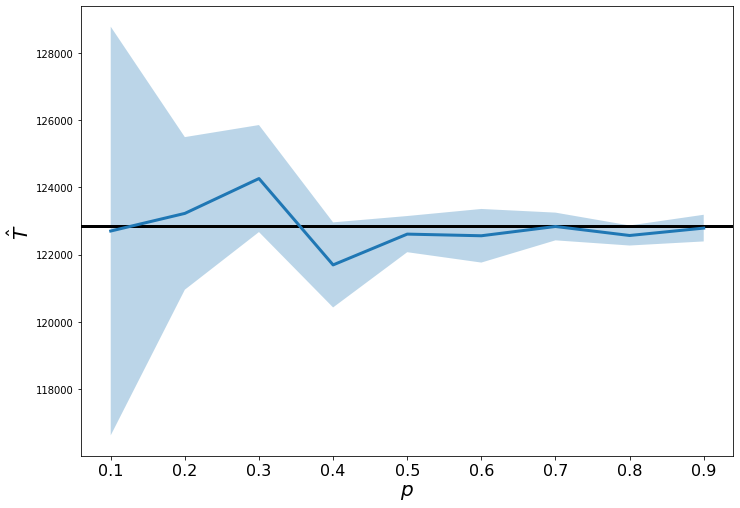

In [38]:
fig, ax = setup_axes('$p$','$\\hat{T}$','linear','linear')

tc = edge_triangle_count(G)
ax.axhline(sum(tc)/3.0, color="black", linewidth=3,label="Real triangle count")

means = np.mean(guesses,axis=0)
stds = np.std(guesses,axis=0)

df = pd.DataFrame(guesses)
df.to_csv("fb_triangle_counts.csv")
means = np.mean(guesses,axis=0)
stds = np.std(guesses,axis=0)

ax.plot(prange,means,label="Estimated triangle count",linewidth=3)
ax.fill_between(prange,means-0.5*stds,means+0.5*stds,alpha=0.3)


In [11]:
def total_triangle_experiment(G, experiments, fname):
    tc = edge_triangle_count(G)
    tri, cdf = ecdf(tc)
    ccdf = 1 - cdf/cdf[-1]

    prange = np.linspace(0.1,0.9,9)
    guesses = np.zeros((experiments, len(prange)))
    
    for ex in range(experiments):
        guesses[ex,:] = np.array(list(map(lambda x: tot_tri_estimate(G,x),prange)))
        
    means = np.mean(guesses,axis=0)
    stds = np.std(guesses,axis=0)

    df = pd.DataFrame(guesses)
    df.to_csv(fname)
    means = np.mean(guesses,axis=0)
    stds = np.std(guesses,axis=0)
    
    return means, sds

In [14]:
G = nx.barabasi_albert_graph(10000,3)

means, sds = total_triangle_experiment(G,10,"BAtest.csv")

NameError: name 'sds' is not defined

## Posterior sampling approach


In [35]:
from math import comb
def gen_distribution(k,p,kmax):
    probs = np.zeros(kmax+1)
    for deg in range(k,kmax + 1):
        probs[deg] = comb(deg,k) * np.power(p,k) * np.power(1-p,deg - k)
    return probs/np.sum(probs)

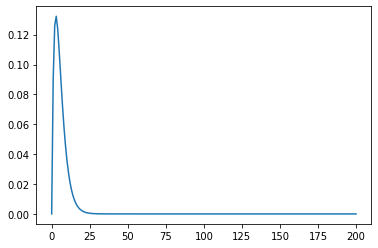

In [10]:
plt.plot(gen_distribution(1,0.3,200))

In [33]:
def sample(dist):
    r = random.random()
    tot = 0.0
    ind = 0
    while tot < r:
        tot += dist[ind]
        ind +=1
    return ind

In [32]:
def est_dist(degs,freqs,p,n):
    isolates = n - sum(freqs)
    newdegs = []
    degs.append(0)
    freqs.append(isolates)
    for i in range(len(degs)):
        k = int(degs[i])
        kmax = int(1/p * k +1)
        fr = freqs[i]
        dist = gen_distribution(k,p,kmax)
        for _ in range(fr):
            newdegs.append(sample(dist))
    # Correction step to ensure right number of edges in total
#     correct_degsum = int(1/p * sum(degs))
#     for i in range(max(0,correct_degsum - sum(newdegs))):
#         j = random.randint(0,len(newdegs)-1)
#         if newdegs[j]>0:
#             newdegs[j]-=1
    return newdegs

In [36]:
G = nx.barabasi_albert_graph(10000,3)
p=0.2
H = edge_sample(G,p)
c = Counter([d for n,d in H.degree()])
degs = sorted(c.keys())
vals = [c[val] for val in degs]

newdegs = est_dist(degs,vals,p,len(G.nodes()))

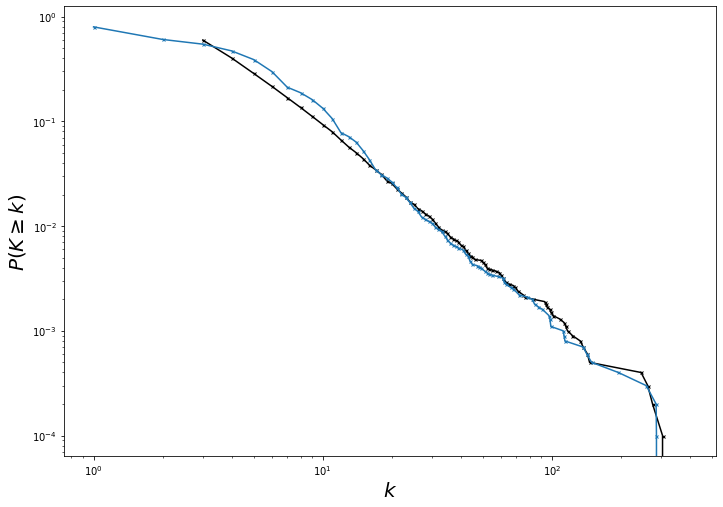

In [37]:
fig, ax = setup_axes('$k$','$P(K\\geq k)$','log','log')
rdegs, rcdf = get_deg_cdf(G)
rcdf = 1 - rcdf/rcdf[-1]
degs, cdf = ecdf(newdegs)
ccdf = 1 - cdf/cdf[-1]

ax.plot(rdegs, rcdf,marker='x',markersize=3,label="real",color='black')
ax.plot(degs, ccdf,marker='x',markersize=3,label="p="+str(0.8))

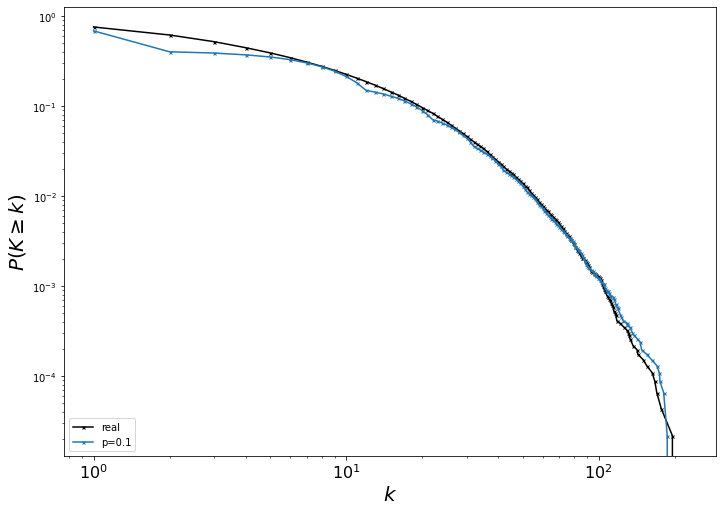

In [36]:
fname="/Users/naomiarnold/CODE/NaomiFETA/FETA3.1/data/facebook.dat"
net = pd.read_csv(fname,sep=" ",names=["source","target","t"])
net = net.drop(["t"], axis=1)
G = nx.from_pandas_edgelist(net)

p=0.1
H = edge_sample(G,p)
c = Counter([d for n,d in H.degree()])
degs = sorted(c.keys())
vals = [c[val] for val in degs]

newdegs = est_dist(degs,vals,p,len(G.nodes()))

fig, ax = setup_axes('$k$','$P(K\\geq k)$','log','log')
rdegs, rcdf = get_deg_cdf(G)
#rcdf = rcdf[-1] - rcdf
rcdf = 1 - rcdf/rcdf[-1]

degs, cdf = ecdf(newdegs)
#ccdf = cdf[-1] - cdf
ccdf = 1 - cdf/cdf[-1]

ax.plot(rdegs, rcdf,marker='x',markersize=3,label="real",color='black')
ax.plot(degs, ccdf,marker='x',markersize=3,label="p="+str(p))
ax.legend(loc="lower left")
plt.show()

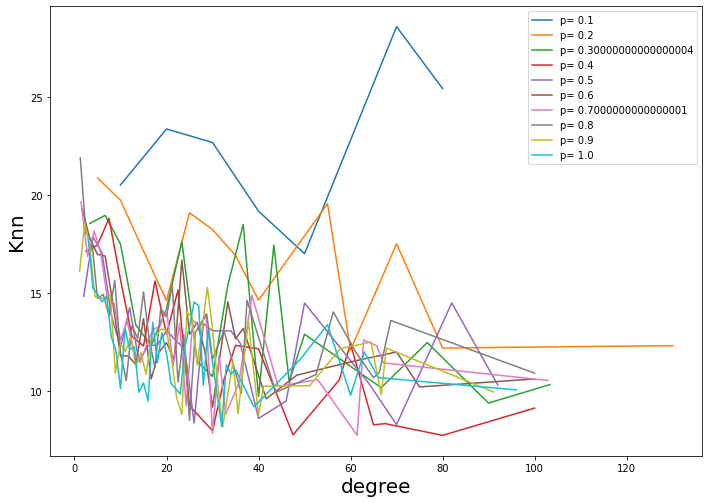

In [68]:
G = nx.barabasi_albert_graph(1000,3)

fig, ax = setup_axes("Degree", "Knn")

for p in np.linspace(0.1,1.0,10):
    H = edge_sample(G,p)
    degrees = [1.0/p * d for n,d in H.degree()]
    knn = nx.average_neighbor_degree(H).values()
    df = pd.DataFrame()
    df['degree']=degrees
    df['knn']=knn
    df['knn']=1.0/p*df['knn']
    grouped = df.groupby('degree').mean()
    grouped.plot(y='knn',ax=ax, label="p= "+str(p))

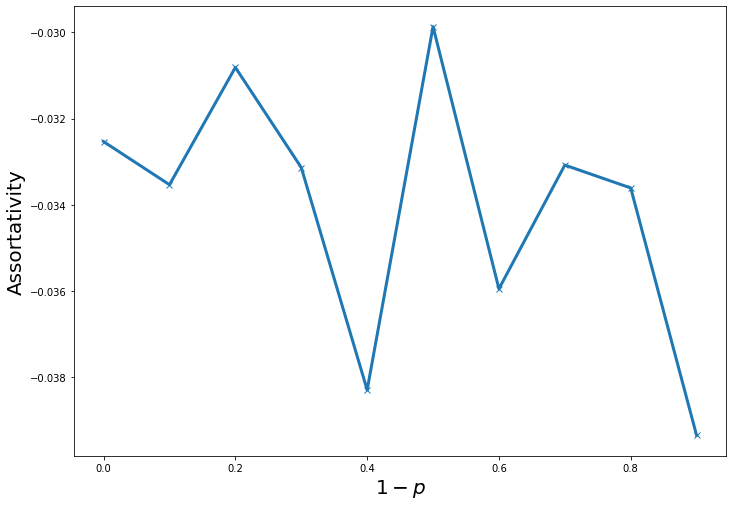

In [132]:
fig, ax = plt.subplots(figsize = a4_dims)

ax.set_xlabel('$1-p$',fontsize=20)
ax.set_ylabel('Assortativity', fontsize=20)

prange = np.linspace(0.1,1.0,10)
y = np.zeros(len(prange))

for i in range(len(prange)-1):
    p = prange[i]
    H = edgesample(G,p)
    tri = nx.degree_assortativity_coefficient(H)
    y[i]=tri

y[-1] = nx.degree_assortativity_coefficient(G)
q = 1-prange

ax.plot(q,y,marker='x',linewidth=3)
plt.show()

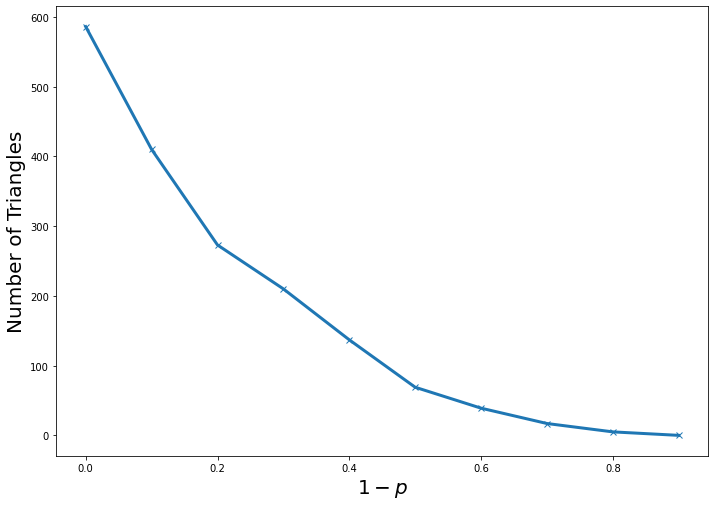

In [25]:
fig, ax = plt.subplots(figsize = a4_dims)

# fname="/Users/narnolddd/CODE/FETA/FETA3/data/facebook.dat"
# net = pd.read_csv(fname,sep=" ",names=["source","target","t"])
# net = net.drop(["t"], axis=1)
# G = nx.from_pandas_edgelist(net)

ax.set_xlabel('$1-p$',fontsize=20)
ax.set_ylabel('Number of Triangles', fontsize=20)

prange = np.linspace(0.1,1.0,10)
y = np.zeros(len(prange))

for i in range(len(prange)-1):
    p = prange[i]
    H = edge_sample(G,p)
    tri = sum(nx.triangles(H).values()) / 3
    y[i]=tri

y[-1]=sum(nx.triangles(G).values()) / 3
q = 1-prange

ax.plot(q,y,marker='x',linewidth=3)
plt.show()